#### Plot cluster FR
This notebook is used to generate Figure 3d. It plots the normalized average firing rate (Min-Max Normalization) for each cluster during different behavioral epochs.

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn import preprocessing as p
%matplotlib inline
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import sem

from matplotlib.gridspec import SubplotSpec

%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

c:\Users\jp\anaconda3\envs\ana_312\Lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
bin_size = 500
opt_norm = True
opt_fr_thres = 5
monkey = 'VM20_VM23'
nLimit = 70
rnd_seed = 42
n_clusters = 3
plot_bin_size = 500
opt_norm = True
t_before = -2000
t_after = 2000
bins = np.arange(t_before, t_after + 1, plot_bin_size)

# Replace path with your data path:
pn_root = r"\\NJJK-NAS\visual\66_paper\MANUSCRIPT\20250610-v6-submit\figShare_upload\DATA"

homedir = glob.glob(os.path.join(pn_root, fr'04_result_{bin_size}ms\b3_task_raster\{monkey}'), recursive=True)[0]
brain_region_list = sorted(next(os.walk(homedir))[1])

In [3]:
# Find brain regions less than nLimit
rm_list = []
for reg in brain_region_list:
    channel_list = sorted(glob.glob(os.path.join(homedir,reg,'*.csv')))
    if len(channel_list) < nLimit:
        rm_list.append(reg)

In [4]:
# remove regions
brain_region_list = list(filter(lambda a: a not in rm_list, brain_region_list))

if opt_norm:
    savedir = os.path.join(homedir.replace(f'04_result_{plot_bin_size}ms', '05_plots'),f'NumOver{nLimit}')
os.makedirs(savedir, exist_ok=True)

# load umap clustering label list
if opt_norm:
    label_list = pd.read_csv(os.path.join(homedir,f'hierarchical_ClusterLabel_{monkey}_{bin_size}ms_normalized_seed{rnd_seed}_ncluster{n_clusters}_numOver{nLimit}.csv'))
else:
    label_list = pd.read_csv(os.path.join(homedir,f'hierarchical_ClusterLabel_{monkey}_{bin_size}ms_seed{rnd_seed}_ncluster{n_clusters}_numOver{nLimit}.csv'))

In [5]:
label_list.head(5)

,Cluster,Region
0,1,01_V1
1,2,01_V1
2,2,01_V1
3,3,01_V1
4,3,01_V1


In [6]:
events = {
    't_reach_start_seg': 't_reach_start',
    't_touch_fruit_seg': 't_touch_fruit',
    't_touch_mouth_seg': 't_touch_mouth',
}

In [7]:
all_psths = {event_name: [] for event_name in events.keys()}
for event_name, event_time_col in events.items():
    # loop through each brain region
    for reg in brain_region_list:
        channel_list = sorted(glob.glob(os.path.join(homedir,reg,'*.csv')))
        onereg = pd.DataFrame()
        for ch_path in channel_list:
            # load 500ms bin FR to do analysis
            df_psth = pd.read_csv(ch_path)
            # use smoothed 50ms bin FR to do quality control
            df_psth_qc = pd.read_csv(ch_path.replace(f'04_result_{bin_size}ms', '04_result_50ms'))
            s_smoothed = pd.concat([df_psth_qc['t_reach_start_seg_smoothed'], df_psth_qc['t_touch_fruit_seg_smoothed'], df_psth_qc['t_touch_mouth_seg_smoothed']], axis=0, ignore_index=True)

            if any(s_smoothed >= opt_fr_thres): # if at any point during the three event epochs, the FR for this channel is greater than opt_fr_thres, keep the channel
                all_psths[event_name].append(df_psth[event_name].values)

    all_psths[event_name] = np.array(all_psths[event_name])

In [8]:
# rescale data
for i, event in enumerate(list(events.keys())):
    if i == 0:
        combined_data = all_psths[event]
    else:
        combined_data = np.hstack((combined_data, all_psths[event]))

min_max_scaler = p.MinMaxScaler()
normalized_combined_data = np.zeros(combined_data.shape)
# rescale each unit 
for row in range(combined_data.shape[0]):
    dd = min_max_scaler.fit_transform(combined_data[row,:].reshape(-1,1))
    normalized_combined_data[row,:] = dd.squeeze()

print(normalized_combined_data.shape)
# re-organize normalized data to dictionary format
split_data = np.hsplit(normalized_combined_data, len(events.keys()))
normalized_all_psths = {event_name: [] for event_name in events.keys()}
for i, event in enumerate(list(events.keys())):
    normalized_all_psths[event] = split_data[i]

(2031, 24)


Cluster #1
Cluster #2
Cluster #3


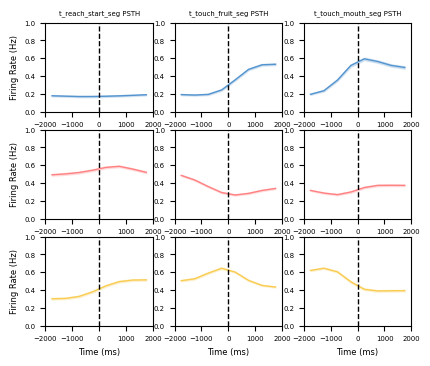

<Figure size 640x480 with 0 Axes>

In [9]:
# define colors
if n_clusters == 2:
    hex_colors = ['#5494CE', '#F9CC52']
elif n_clusters == 3:
    hex_colors = ['#5494CE', '#FF8283', '#F9CC52']
elif n_clusters == 4:
    hex_colors = ['#5494CE', '#FF8283', '#0D898A', '#F9CC52']
elif n_clusters == 6:
    hex_colors = ['#f57c6e', '#f2b56f', '#84c3b7', '#71b7ed', '#b8aeeb', '#f2a7da']

# convert inches to centimeters
cm = 1/2.54
time = bins[:-1] + (bins[1] - bins[0]) / 2
num_events = len(events.keys())
fig, axes = plt.subplots(n_clusters, num_events, figsize=(12*cm, 10*cm))
grid = plt.GridSpec(n_clusters, num_events)

for cl in range(n_clusters):
    print(f'Cluster #{cl+1}')
    idx = label_list.index[label_list['Cluster']==cl+1].tolist()
    for i, event in enumerate(list(events.keys())):
        # 绘制反应曲线
        ax_psth = axes[cl, i]
        mean_rates = np.mean(normalized_all_psths[event][idx,:], axis=0)
        sem_rates = sem(normalized_all_psths[event][idx,:], axis=0)
        rates = gaussian_filter1d(mean_rates, sigma=1)
        error = gaussian_filter1d(sem_rates, sigma=1)
        ax_psth.plot(time, rates, label=event, color=hex_colors[cl], linewidth=1)
        ax_psth.fill_between(time, rates - error, rates + error, color=hex_colors[cl], alpha=0.2)
        ax_psth.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Event Time')
        ax_psth.set_xlim([t_before, t_after])
        ax_psth.set_ylim([0, 1])
        ax_psth.tick_params(axis='x', labelsize=5)
        ax_psth.tick_params(axis='y', labelsize=5)
        axes[0][i].set_title(f'{event} PSTH', fontsize=5)
        axes[n_clusters-1][i].set_xlabel('Time (ms)', fontsize=6)
        axes[cl][0].set_ylabel('Firing Rate (Hz)', fontsize=6)

plt.savefig(os.path.join(savedir,f'norFR_{plot_bin_size}ms_seed{rnd_seed}_ncluster{n_clusters}.png'))
plt.savefig(os.path.join(savedir,f'norFR_{plot_bin_size}ms_seed{rnd_seed}_ncluster{n_clusters}.pdf'), transparent=True, bbox_inches="tight")
plt.show()
plt.clf()